<a href="https://colab.research.google.com/github/Enterprise-J/CS284A_HW3/blob/main/hw3_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CS184A/284A: AI in Biology and Medicine
# HW3


# Predicting TF Binding Sites

Transcription Factors (TFs) are proteins that bind to the DNA and help regulate gene transcription. The TFs have to recognize some "motif" on the DNA upstream from the gene, and DNA accessibility also plays a role.

In tis problem set, we will develop ML methods to predict which sequences can be bound by a transcription factor called JUND.  The binding profile of JUND expressed in terms of a sequence logo is shown in the following picture.

More information on JUND can be found here:
- https://www.genecards.org/cgi-bin/carddisp.pl?gene=JUND

fatal: destination path 'CS284A_HW3' already exists and is not an empty directory.


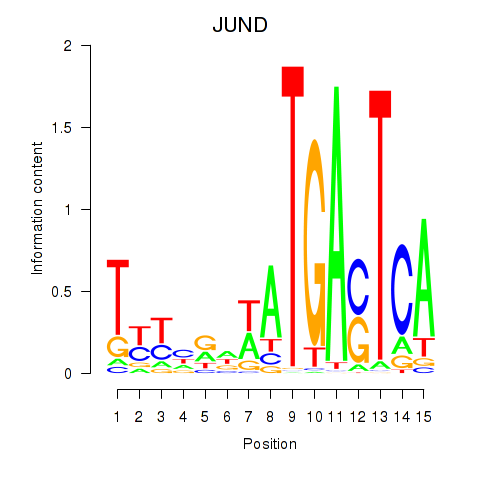

In [2]:
!git clone https://github.com/Enterprise-J/CS284A_HW3
import numpy as np
# get the image
from IPython import display
display.Image("https://www.ismara.unibas.ch/ISMARA/scratch/NHBE_SC2/ismara_report/logos/JUND.png", width=350)


## MLP model

In this assignment you'll write an MLP model the predict whether a segments of the human chromosome 22 (Chr22) contain the binding sites for the JUND TF. You can modify the mlp notebook I shared with you to work on this problem. You need to have at least one hidden layer. You have to compute a weighted loss, and include accessibility information in your model, as described below.



## Dataset
The data comprises 101 length segments from Chr22, with each position a one-hot vector denoting one of the four bases (A, C, G, T). Thus, each element of the input is 2d with size 101×4. Each such element has a target label 0 or 1, indicating whether the TF binds to that segment or not. The data also includes a weight per input element, since there are only a few binding sites (0.42%), so that you'd obtain an accuracy of 99.58% just by predicting there are no binding sites. This means you have to use the weights to discount the losses for label 0 and enhance the losses for label 1 items. Finally, there is an array of values, one per input element, that also indicates the chromosome accessibility for that segment.


Data Credit: Mohammed Zaki

## Download data



*   First, you need to download data file named "TF_data.zip" from Canvas. Unzip it and create the train, valid, test directories.

*   If you use Google Colab, you can first upload the TF_data.zip file, and then run the follow command

<center><code>!unzip TF_data.zip</code></center>

*   The data is split into training, validation and testing sets. Each set contains the following files:
  * shard-0-X.joblib: the set of 101 x 4 input elements
  * shard-0-y.joblib: the true labels: 0 or 1
  * shard-0-w.joblib: weight per input element
  * shard-0-a.joblib: accessibility value per input element

*   After unzip the data file, you  can read these files by using joblib.load function, which will populate a numpy array. For example
<center><code>X = joblib.load('shard-0-X.joblib')</code></center>
will results in a numpy array X, which you can then convert to torch tensor, and so on.

*  The roles of training, validation and testing sets:
  * Use training set to tune the parameters of the model.
  * Use validation set to select model structure and hyperparamters (e.g., number of epochs, learning rate, etc).
  * Use test set for the final evaluation.  You should never touch test set for either your model training or model selection.

In [2]:
# Uncomment the following command if you run this code in Google Colab
#!unzip TF_data.zip

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import joblib
import random
from sklearn.metrics import precision_score, recall_score, confusion_matrix, f1_score

## Set up DataLoader for fetching training and testing data

Because we use mini-batch gradient descent for training.  We need to set up dataloader that can provide us a minibatch of data samples.



In [15]:
def setup_seed(seed):
     torch.manual_seed(seed)
     torch.cuda.manual_seed_all(seed)
     np.random.seed(seed)
     random.seed(seed)
     torch.backends.cudnn.deterministic = True

setup_seed(3407)

from torch._C import dtype
from torch.utils.data import Dataset

class JUND_Dataset(Dataset):
    def __init__(self, data_dir):
        '''load X, y, w, a from data_dir'''
        super(JUND_Dataset, self).__init__()

        # load X, y, w, a from given data_dir
        # convert them into torch tensors
        self.X = torch.from_numpy(joblib.load(data_dir + '/shard-0-X.joblib')).float()
        self.y = torch.from_numpy(joblib.load(data_dir + '/shard-0-y.joblib')).float()
        self.w = torch.from_numpy(joblib.load(data_dir + '/shard-0-w.joblib')).float()
        self.a = torch.from_numpy(joblib.load(data_dir + '/shard-0-a.joblib')).float()

    def __len__(self):
        '''return len of dataset'''
        return self.X.shape[0]

    def __getitem__(self, idx):
        '''return X, y, w, and a values at index idx'''
        return self.X[idx],self.y[idx],self.w[idx], self.a[idx]

In [16]:
# get data
#
# You may need to change the directory if the data are not stored under current directory
#
train_dataset = JUND_Dataset('CS284A_HW3/train_dataset')
test_dataset = JUND_Dataset('CS284A_HW3/test_dataset')
valid_dataset = JUND_Dataset('CS284A_HW3/valid_dataset')

### Traing and test data

In [17]:
batch_size = 512

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)
valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

In [18]:
print('Train data: ', len(train_dataset))
print('Test data: ', len(test_dataset))
print('Valid data: ', len(valid_dataset))

Train data:  276216
Test data:  34528
Valid data:  34527


Your result should look like:

```
Train data:  276216
Test data:  34528
```



### Fetch a minibatch and check the size of the data

In [19]:
X,y,w,a = next(iter(train_loader))

In [20]:
# run the following code to check the size of data in each minibatch
X.shape, y.shape, w.shape, a.shape

(torch.Size([512, 101, 4]),
 torch.Size([512, 1]),
 torch.Size([512, 1]),
 torch.Size([512, 1]))

Your result should look like the following:

```
(torch.Size([100, 101, 4]),
 torch.Size([100, 1]),
 torch.Size([100, 1]),
 torch.Size([100, 1]))
```



# Problem 1 - MLP

Define an MLP (multi-layer perceptron) with at least one hidden layer to predict the labels given inputs.

Please note the following:

- The label for each input is either 0 or 1, so this is essentially a binary classification problem.
- Input consist of both X and a:
  - X: represents the DNA sequence. Each position is a one-hot vector denoting one of the four bases (A, C, G, T). Thus, each element of the input is 2d with size 101×4.   Since each input is treated as a vector in MLP, the 2d array needs to be flattened into a 404-dimensional vector.
  - a: represents the chromatin accessiblity of the input DNA sequence segment. You can think of "a" as an additional feature for each input. You can decide how to use it.  For instance, if you are using hidden dimension of 128, then after concatenating the accessibility value, it will become a 129d vector, which should be fed to the final output layer of size 1, since we have a binary class/label.

An initial template code, representing a simple model, is provided.  Your job is to change the definition of the model to improve the model's performance on the test dataset.


In [10]:
###############################################################################
#  modify this code block
###############################################################################
# MLP
class MyModel(nn.Module):
    def __init__(self, input_size=101*4, hidden_size=45):
        super(MyModel, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU())
        self.fc = nn.Sequential(
            nn.BatchNorm1d(hidden_size+1),
            nn.Linear(hidden_size+1, 1))

    def forward(self, X, a):
        out = X.reshape(X.size(0),-1)
        out = self.layer1(out)
        out = torch.cat((out, a),1)
        out = self.fc(out)
        return out
# end of model definition
###############################################################################

### Have a test run of your model

In [11]:
model = MyModel()
output = model(X,a)

Your model should run smoothly.  The size of output should be 100 - the same as the minibatch size.

# Training

Next you need to define a loss function and then run gradient descend to learn the weights of the neural net.

- There is a strong class imbalance problem in the training set (many more 0's than 1's).

- To handle the class imbalance problem, we treat each sample differently.  Each data point is assigned a weight. Take a look at the variable named "w" in each data set.

- Define a loss function, in which the total loss is a weighted combination of losses coming from each sample.  Use the weights specified in "w".   Note that this definition is different from our typical loss, where each sample contributes equally to the final total loss.

- You should use binary_cross_entropy_with_logits with weight set to the weights per input element. Check out the documentation for details.

In [12]:
###############################################################
# complete this code block
# define loss and optimizer
###############################################################
criterion = nn.BCEWithLogitsLoss()
###############################################################

In [13]:
# have a test run to check of your loss is defined properly
loss = criterion(output, y)

In [14]:
loss

tensor(0.7385, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


## You task:

You need to train the model on the training data, and use the **validation data** to select how many epochs you want to use and to choose the hidden dimension.

Use the **weighted prediction accuracy** as the evaluation metric. That is, sum of the weights of the correct predictions divided by the total weight across all the input elements.

Finally, report the **weighted accuracy on the test data.**

### Run Training

In [15]:
# Choose hyper parameters and optimizer
num_epochs = 20
learning_rate = 0.003
optimizer = torch.optim.Adam(params=model.parameters(),lr=learning_rate)

In [16]:
# Train the model
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (X, y, w, a) in enumerate(train_loader):
        # images = images.to(device)
        # labels = labels.to(device)

        # Forward pass
        output = model(X, a)
        criterion.weight = w
        loss = criterion(output, y)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))


Epoch [1/20], Step [100/540], Loss: 0.4765
Epoch [1/20], Step [200/540], Loss: 0.6872
Epoch [1/20], Step [300/540], Loss: 0.3245
Epoch [1/20], Step [400/540], Loss: 0.5343
Epoch [1/20], Step [500/540], Loss: 0.3559
Epoch [2/20], Step [100/540], Loss: 0.3082
Epoch [2/20], Step [200/540], Loss: 1.2386
Epoch [2/20], Step [300/540], Loss: 0.2494
Epoch [2/20], Step [400/540], Loss: 0.4982
Epoch [2/20], Step [500/540], Loss: 0.5976
Epoch [3/20], Step [100/540], Loss: 0.2493
Epoch [3/20], Step [200/540], Loss: 0.3028
Epoch [3/20], Step [300/540], Loss: 0.7940
Epoch [3/20], Step [400/540], Loss: 0.4980
Epoch [3/20], Step [500/540], Loss: 0.6822
Epoch [4/20], Step [100/540], Loss: 0.2297
Epoch [4/20], Step [200/540], Loss: 0.2509


KeyboardInterrupt: ignored

### Run Validation

In [ ]:
import itertools

y_pred_list = []
y_target_list = []

# Weights
w_list = []

model.eval()
#Since we don't need model to back propagate the gradients in test set we use torch.no_grad()
# reduces memory usage and speeds up computation
with torch.no_grad():
     for i, (X, y, w, a) in enumerate(valid_loader):
        output = model(X, a)
        y_pred_tag = (output>0).int()
        y_pred_list.append(y_pred_tag.detach().numpy())
        y_target_list.append(y.detach().numpy())

        # Weights
        w_list.append(w.detach().numpy())

#Takes arrays and makes them list of list for each batch
y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
#flattens the lists in sequence
yvalid_pred = list(itertools.chain.from_iterable(y_pred_list))


#Takes arrays and makes them list of list for each batch
y_target_list = [a.squeeze().tolist() for a in y_target_list]
#flattens the lists in sequence
yvalid_target = list(itertools.chain.from_iterable(y_target_list))

# Weights
#Takes arrays and makes them list of list for each batch
w_list = [a.squeeze().tolist() for a in w_list]
#flattens the lists in sequence
wvalid_list = list(itertools.chain.from_iterable(w_list))

In [ ]:
# define weighted prediction accuracy
def weight_accuracy(predicted_y, true_y, weight):
    return np.sum(np.array(weight)[np.array(predicted_y) == np.array(true_y)])/np.sum(np.array(weight))

weight_accuracy(yvalid_pred,yvalid_target,wvalid_list)

## Final Evaluation

### Generate predictions on test set

In [ ]:
import itertools

y_pred_list = []
y_target_list = []

# Weights
w_list = []

model.eval()
#Since we don't need model to back propagate the gradients in test set we use torch.no_grad()
# reduces memory usage and speeds up computation
with torch.no_grad():
     for i, (X, y, w, a) in enumerate(test_loader):
        output = model(X, a)
        y_pred_tag = (output>0).int()
        y_pred_list.append(y_pred_tag.detach().numpy())
        y_target_list.append(y.detach().numpy())
        
        # Weights
        w_list.append(w.detach().numpy())

#Takes arrays and makes them list of list for each batch
y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
#flattens the lists in sequence
ytest_pred = list(itertools.chain.from_iterable(y_pred_list))


#Takes arrays and makes them list of list for each batch
y_target_list = [a.squeeze().tolist() for a in y_target_list]
#flattens the lists in sequence
ytest_target = list(itertools.chain.from_iterable(y_target_list))

# Weights
#Takes arrays and makes them list of list for each batch
w_list = [a.squeeze().tolist() for a in w_list]
#flattens the lists in sequence
wtest_list = list(itertools.chain.from_iterable(w_list))

### Report
- Precision
- Recall
- F1 Score
- Confusion Matrix

In [ ]:
conf_matrix = confusion_matrix(ytest_target ,ytest_pred)
print("Confusion Matrix of the Test Set")
print("-----------")
print(conf_matrix)
print("Precision of the MLP :\t"+str(precision_score(ytest_target,ytest_pred)))
print("Recall of the MLP    :\t"+str(recall_score(ytest_target,ytest_pred)))
print("F1 Score of the Model :\t"+str(f1_score(ytest_target,ytest_pred)))

##  Write code to **weighted prediction accuracy**

That is, sum of the weights of the correct predictions divided by the total weight across all the input elements.

Report the weighted accuracy on the test data.



In [ ]:
###########################################################
#
#  Complete the following function which calculates weight prediction accuracy
#

def weight_accuracy(predicted_y, true_y, weight):
    return np.sum(np.array(weight)[np.array(predicted_y) == np.array(true_y)])/np.sum(np.array(weight))

###########################################################

In [ ]:
# calculate weighted accuracy on the test data
weight_accuracy(ytest_pred,ytest_target,wtest_list)

# Problem 2 - CNN

- Define a CNN model to solve the above problem.
- The CNN model receives the same inputs. Instead of using MLP, it uses convolution to extract features.
- Different from 2d images, the convolution will be 1d convolution
- Again, use validation set to design your model and select hyperparamters.
- Report weight accuracy on test set
- Comment on your observations.

## CNN Details
- For the CNN model, you have to use the 1D convolution module. The in_channels will be 4, one per DNA base. You can decide what number of out_channels and kernel size you want to use.

- Check out torch Conv1d

```
torch.nn.Conv1d(in_channels, out_channels, kernel_size, stride=1, padding=0)
```


- Note the dimensions of the input required for the 1D convolution -- (N,C,L) a where N is a batch size, C denotes a number of channels, L is a length of signal sequence.

- That is the input sequence has to be 4×101 and not 101×4 as in the data. So you should use torch.swapaxes function to swap the last two axes (not the batch axis) in the forward function.

After the Conv1d, you can apply a relu activation, do dropout, and then try a maxpooling layer (1d). You can try more than one convolution layer too.

Finally, flatten out the last convolution layer and use as input to an MLP.

In [33]:
class MyConvModel(nn.Module):
    def __init__(self):
        super(MyConvModel, self).__init__()
        hidden_size = 128

        self.conv1 = nn.Sequential(
            nn.Conv1d(in_channels=4,out_channels=64,kernel_size=4,stride=1,padding='same'),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.MaxPool1d(kernel_size=2,stride=2))

        self.conv2 = nn.Sequential(
            nn.Conv1d(in_channels=64,out_channels=128,kernel_size=4,stride=1,padding='same'),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.MaxPool1d(kernel_size=2,stride=2))
        
        self.conv3 = nn.Sequential(
            nn.Conv1d(in_channels=128,out_channels=256,kernel_size=4,stride=1,padding='same'),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.MaxPool1d(kernel_size=2,stride=2))
        
        self.flatten = nn.Flatten()

        self.dense1 = nn.Sequential(
            nn.LazyLinear(out_features=hidden_size),
            nn.ReLU())

        self.output = nn.Sequential(
            nn.BatchNorm1d(num_features=hidden_size+1),
            nn.Linear(in_features=hidden_size+1, out_features=1))

    def forward(self, X, a):
        out = torch.transpose(X,1,2)
        out = self.conv1(out)
        out = self.conv2(out)
        out = self.conv3(out)
        out = self.flatten(out)
        out = self.dense1(out)
        out = torch.cat((out, a),1)
        out = self.output(out)
        return out

In [43]:
# define weighted prediction accuracy
def weight_accuracy(predicted_y, true_y, weight):
    return np.sum(np.array(weight)[np.array(predicted_y) == np.array(true_y)]) / np.sum(np.array(weight))

def accuracy_wrap(model,dataloder):
    import itertools

    y_pred_list = []
    y_target_list = []

    # Weights
    w_list = []

    model.eval()
    #Since we don't need model to back propagate the gradients in test set we use torch.no_grad()
    # reduces memory usage and speeds up computation
    with torch.no_grad():
        for i, (X, y, w, a) in enumerate(dataloder):
            output = model(X.cuda(), a.cuda())
            y_pred_tag = (output > 0).int()
            y_pred_list.append(y_pred_tag.detach().to('cpu').numpy())
            y_target_list.append(y.detach().to('cpu').numpy())

        # Weights
            w_list.append(w.detach().numpy())

    #Takes arrays and makes them list of list for each batch
    y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
    #flattens the lists in sequence
    yvalid_pred = list(itertools.chain.from_iterable(y_pred_list))

    #Takes arrays and makes them list of list for each batch
    y_target_list = [a.squeeze().tolist() for a in y_target_list]
    #flattens the lists in sequence
    yvalid_target = list(itertools.chain.from_iterable(y_target_list))

    # Weights
    #Takes arrays and makes them list of list for each batch
    w_list = [a.squeeze().tolist() for a in w_list]
    #flattens the lists in sequence
    wvalid_list = list(itertools.chain.from_iterable(w_list))

    return weight_accuracy(yvalid_pred, yvalid_target, wvalid_list)



In [44]:
conv_model = MyConvModel().cuda()

In [45]:
criterion = nn.BCEWithLogitsLoss()

# Choose hyper parameters and optimizer
num_epochs = 40
learning_rate = 0.001
optimizer = torch.optim.Adam(params=conv_model.parameters(), lr=learning_rate)
# Train the model
total_step = len(train_loader)

err_train = np.zeros(shape=num_epochs)
err_valid = np.zeros(shape=num_epochs)

for epoch in range(num_epochs):
    for i, (X, y, w, a) in enumerate(train_loader):
        # images = images.to(device)
        # labels = labels.to(device)
        X = X.cuda()
        y = y.cuda()
        w = w.cuda()
        a = a.cuda()

        # Forward pass
        output = conv_model(X, a)
        criterion.weight = w
        loss = criterion(output, y)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    err_train[epoch] = accuracy_wrap(conv_model,train_loader)
    err_valid[epoch] = accuracy_wrap(conv_model,valid_loader)


    print('Epoch', epoch+1,'| train:',round(err_train[epoch],4) ,'| valid:',round(err_valid[epoch],4))

    if err_valid[epoch] > 0.81:
      break

Epoch 1 | train: 0.7397 | valid: 0.7288
Epoch 2 | train: 0.7328 | valid: 0.7286
Epoch 3 | train: 0.7357 | valid: 0.7341
Epoch 4 | train: 0.7321 | valid: 0.7284
Epoch 5 | train: 0.7357 | valid: 0.7337
Epoch 6 | train: 0.7407 | valid: 0.7309
Epoch 7 | train: 0.7286 | valid: 0.7205
Epoch 8 | train: 0.739 | valid: 0.7329
Epoch 9 | train: 0.7406 | valid: 0.7409
Epoch 10 | train: 0.7593 | valid: 0.7561
Epoch 11 | train: 0.7967 | valid: 0.7868
Epoch 12 | train: 0.8022 | valid: 0.8126


After several trials of tunning, the performance stopped increasing with validation accuracy between 0.81 and 0.82, so a stop criteria was set to 0.81.

weighted accuracy on test set:

In [127]:
accuracy_wrap(conv_model,test_loader)

0.8128426919235392

# Problem 3 - LSTM

- For the LSTM model, use the encoder followed by a two layer MLP approach. That is, pass the input sequence (batch) through the LSTM and use the last hidden layer as the representation or embedding vector for the sequence. You can choose the dimensionality of the hidden layer. Next, use this vector as input to a two fully connected MLP layers -- the first connects the input vector to the hidden layer (again you can choose the size of the hidden layer), and the second connects the hidden to the output neuron. Use dropout and relu as appropriate.

- Keep in mind that for the input to the LSTM module in pytorch use batch_first=True. This means that the batch dimension comes first, so the input is (N×101×4), which is how the input data is structured. Make note of the output of the LSTM layer so that you store the last hidden layer as the representation, to be used as input to the MLP layers.

- Also, before feeding the output of the hidden layer to the output layer, you must concatenate the accessibility value. So if you are using hidden dimension of 128, then after concatenating the accessibility value, it will become a 129d vector, which should be fed to the final output layer of size 1, since we have a binary class/label.

- You should use binary_cross_entropy_with_logits with weight set to the weights per input element.

- You need to train the model on the training data, and use the validation data to select how many epochs you want to use and to choose the hidden dimension. Use the weighted prediction accuracy as the evaluation metric. That is, sum of the weights of the correct predictions divided by the total weight across all the input elements. Finally, report the weighted accuracy on the test data.


In [118]:
class MyRecuModel(nn.Module):
    def __init__(self):
      self.hidden_size = 128
      self.layers = 2
      self.direction = 2
      super(MyRecuModel, self).__init__()
      self.lstm = nn.LSTM(input_size = 4, hidden_size = self.hidden_size, 
                          num_layers = self.layers, batch_first=True, dropout=0.5,
                          bidirectional = True)

      self.dense = nn.Sequential(
          nn.BatchNorm1d(num_features = self.layers*self.hidden_size*self.direction),
          nn.Linear(in_features = self.layers*self.hidden_size*self.direction, 
                    out_features=self.layers*self.hidden_size*self.direction),
          nn.Sigmoid())
        
      self.output = nn.Sequential(
          nn.BatchNorm1d(num_features = self.layers*self.hidden_size*self.direction+1),
          nn.Linear(in_features=self.layers*self.hidden_size*self.direction+1, out_features=1))

    def forward(self, X, a):
      batch_size = X.shape[0]

      hidden = (torch.zeros(self.layers*self.direction, batch_size, self.hidden_size).cuda(), 
                torch.zeros(self.layers*self.direction, batch_size, self.hidden_size).cuda())

      _, (hidden_out, _) = self.lstm(X, hidden)
      hidden_out = torch.squeeze(hidden_out)

      hidden_out = torch.transpose(hidden_out,0,1)
      hidden_out = torch.reshape(hidden_out,(batch_size,
                                             self.layers*self.hidden_size*self.direction))

      out = self.dense(hidden_out)
      out = torch.cat((out, a),1)
      out = self.output(out)
      return out





In [119]:
recu_model = MyRecuModel().cuda()

In [122]:
criterion = nn.BCEWithLogitsLoss()

# Choose hyper parameters and optimizer
num_epochs = 10
learning_rate = 0.001
optimizer = torch.optim.Adam(params=recu_model.parameters(), lr=learning_rate)
# Train the model
total_step = len(train_loader)

err_train = np.zeros(shape=num_epochs)
err_valid = np.zeros(shape=num_epochs)

for epoch in range(num_epochs):
    recu_model.train()

    for i, (X, y, w, a) in enumerate(train_loader):

        X = X.cuda()
        y = y.cuda()
        w = w.cuda()
        a = a.cuda()

        # Forward pass
        output = recu_model(X, a)
        criterion.weight = w
        loss = criterion(output, y)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    err_train[epoch] = accuracy_wrap(recu_model,train_loader)
    err_valid[epoch] = accuracy_wrap(recu_model,valid_loader)

    print('Epoch', epoch+1,'| train:',round(err_train[epoch],4) ,'| valid:',round(err_valid[epoch],4))

Epoch 1 | train: 0.6822 | valid: 0.6885
Epoch 2 | train: 0.734 | valid: 0.7405
Epoch 3 | train: 0.7364 | valid: 0.745
Epoch 4 | train: 0.7172 | valid: 0.7206
Epoch 5 | train: 0.7051 | valid: 0.6995
Epoch 6 | train: 0.6356 | valid: 0.6307
Epoch 7 | train: 0.5074 | valid: 0.5025
Epoch 8 | train: 0.6218 | valid: 0.6123
Epoch 9 | train: 0.6807 | valid: 0.6842
Epoch 10 | train: 0.7323 | valid: 0.7273


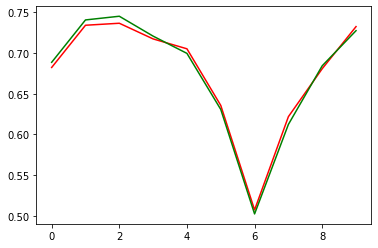

In [123]:
plt.plot(err_train, color='r')
plt.plot(err_valid, color='g')
plt.show()

weighted accuracy on test set:

In [128]:
accuracy_wrap(recu_model,test_loader)

0.7342331474673884

# Statement of Collaboration

It is mandatory to include a Statement of Collaboration in each submission, with respect to the guidelines below.
Include the names of everyone involved in the discussions (especially in-person ones), and what was discussed.

All students are required to follow the academic honesty guidelines posted on the course website.
For programming assignments, in particular, I encourage the students to organize (perhaps using Campuswire) to discuss the task descriptions, requirements, bugs in my code, and the relevant technical content before they start working on it.

However, you should not discuss the specific solutions, and, as a guiding principle, you are not allowed to take anything written or drawn away from these discussions (i.e. no photographs of the blackboard, written notes, referring to Campuswire, etc.).

Especially after you have started working on the assignment, try to restrict the discussion to Campuswire as much as possible, so that there is no doubt as to the extent of your collaboration.


##  Complete your statement of collaboration here:



This homework was done completely by Jiachen Sun without collaboration.

# What to submit
- Export a notebook as PDF
  - Go to Main menu | File and select Print . pdf.

- Upload your jupyter notebook PDF on gradescope

- The notebook must have output values for the final test accuracy.

- Do not submit the data file or directories.